# COVID-19 Hospital Resource Management
## Data Mining - VU Amsterdam
### Authors: Kimberley Boersma, Selma Muhammad, Neil Mizzi - Group 26

In [2]:
# Imports
import os
import pandas as pd
import kaggle

# other imports
import numpy as np 
import matplotlib.pyplot as plt 
import matplotlib.colors as mcolors
import random
import math
import time
from sklearn.linear_model import LinearRegression, BayesianRidge
from sklearn.model_selection import RandomizedSearchCV, train_test_split
from sklearn.preprocessing import PolynomialFeatures
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error, mean_absolute_error
import datetime
import operator 
plt.style.use('fivethirtyeight')
%matplotlib inline 

## Download datasets from Kaggle

In [3]:
kaggle.api.authenticate()
kaggle.api.dataset_download_files('paultimothymooney/ihmes-covid19-projections', path='./kaggle/input/ihmes-covid19-projections/', unzip=True)
kaggle.api.dataset_download_files('benhamner/jhucovid19', path='./kaggle/input/jhucovid19/', unzip=True)

## Load JHU data

In [6]:
# Get Time-Series Data of cases as Pandas DataFrame
dir_jhu = './kaggle/input/jhucovid19/csse_covid_19_data/csse_covid_19_daily_reports'
#files = [(os.path.join(dirname, filename) for filename in filenames if ('gitignore' not in filename and 'README' not in filename)) for dirname, _, filenames in os.walk(dir)]

df_list = []
for dirname, _, files in os.walk(dir_jhu):
    for file in files:
        if 'gitignore' not in file and 'README' not in file:
            full_dir = os.path.join(dirname, file)
            #print(full_dir)
            df_list.append(pd.read_csv(full_dir))
jhu_df = pd.concat(df_list, axis=0, ignore_index=True, sort=True)

jhu_df

,Active,Admin2,Combined_Key,Confirmed,Country/Region,Country_Region,Deaths,FIPS,Last Update,Last_Update,Lat,Latitude,Long_,Longitude,Province/State,Province_State,Recovered
0,NaN,NaN,NaN,1.0,Mainland China,NaN,NaN,NaN,1/22/2020 17:00,NaN,NaN,NaN,NaN,NaN,Anhui,NaN,NaN
1,NaN,NaN,NaN,14.0,Mainland China,NaN,NaN,NaN,1/22/2020 17:00,NaN,NaN,NaN,NaN,NaN,Beijing,NaN,NaN
2,NaN,NaN,NaN,6.0,Mainland China,NaN,NaN,NaN,1/22/2020 17:00,NaN,NaN,NaN,NaN,NaN,Chongqing,NaN,NaN
3,NaN,NaN,NaN,1.0,Mainland China,NaN,NaN,NaN,1/22/2020 17:00,NaN,NaN,NaN,NaN,NaN,Fujian,NaN,NaN
4,NaN,NaN,NaN,NaN,Mainland China,NaN,NaN,NaN,1/22/2020 17:00,NaN,NaN,NaN,NaN,NaN,Gansu,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95583,363.0,NaN,West Bank and Gaza,437.0,NaN,West Bank and Gaza,3.0,NaN,NaN,2020-04-19 23:40:41,31.952200,NaN,35.233200,NaN,NaN,NaN,71.0
95584,6.0,NaN,Western Sahara,6.0,NaN,Western Sahara,0.0,NaN,NaN,2020-04-19 23:40:41,24.215500,NaN,-12.885800,NaN,NaN,NaN,0.0
95585,1.0,NaN,Yemen,1.0,NaN,Yemen,0.0,NaN,NaN,2020-04-19 23:40:41,15.552727,NaN,48.516388,NaN,NaN,NaN,0.0
95586,25.0,NaN,Zambia,61.0,NaN,Zambia,3.0,NaN,NaN,2020-04-19 23:40:41,-13.133897,NaN,27.849332,NaN,NaN,NaN,33.0


## Load IHMES data

In [7]:
#changed the directory to fix the error
dir_ihmes = './kaggle/input/ihmes-covid19-projections/2020_04_16.05/Hospitalization_all_locs.csv'
df_ihmes = pd.read_csv(dir_ihmes)

df_ihmes

,V1,location_name,date,allbed_mean,allbed_lower,allbed_upper,ICUbed_mean,ICUbed_lower,ICUbed_upper,InvVen_mean,...,newICU_upper,totdea_mean,totdea_lower,totdea_upper,bedover_mean,bedover_lower,bedover_upper,icuover_mean,icuover_lower,icuover_upper
0,1,Wyoming,2020-01-03,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000,0.000,0.000,0.0,0.0,0.0,0.0,0.0,0.0
1,2,Wyoming,2020-01-04,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000,0.000,0.000,0.0,0.0,0.0,0.0,0.0,0.0
2,3,Wyoming,2020-01-05,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000,0.000,0.000,0.0,0.0,0.0,0.0,0.0,0.0
3,4,Wyoming,2020-01-06,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000,0.000,0.000,0.0,0.0,0.0,0.0,0.0,0.0
4,5,Wyoming,2020-01-07,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000,0.000,0.000,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
30525,211,Abruzzo,2020-07-31,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,286.209,254.975,354.025,0.0,0.0,0.0,0.0,0.0,0.0
30526,212,Abruzzo,2020-08-01,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,286.209,254.975,354.025,0.0,0.0,0.0,0.0,0.0,0.0
30527,213,Abruzzo,2020-08-02,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,286.209,254.975,354.025,0.0,0.0,0.0,0.0,0.0,0.0
30528,214,Abruzzo,2020-08-03,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,286.209,254.975,354.025,0.0,0.0,0.0,0.0,0.0,0.0


## Preprocessing the JHU dataset
### Source code: https://www.kaggle.com/therealcyberlord/coronavirus-covid-19-visualization-prediction/notebook

In [9]:
# ? In the original code this updates automatically, but I'm not sure if that's the case for us? What do you think?

confirmed_df = pd.read_csv('https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv')
deaths_df = pd.read_csv('https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_deaths_global.csv')
recoveries_df = pd.read_csv('https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_recovered_global.csv')
latest_data = pd.read_csv('https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_daily_reports/04-19-2020.csv')



In [10]:
# Printing a sample of the dataset
recoveries_df[::12] 

# we can see that there are many NaN values for province/state col, but for Country/Region there are no empty cells. 

,Province/State,Country/Region,Lat,Long,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,...,4/10/20,4/11/20,4/12/20,4/13/20,4/14/20,4/15/20,4/16/20,4/17/20,4/18/20,4/19/20
0,NaN,Afghanistan,33.0000,65.0000,0,0,0,0,0,0,...,32,32,32,32,40,43,54,99,112,131
12,South Australia,Australia,-34.9285,138.6007,0,0,0,0,0,0,...,179,179,179,179,240,240,279,331,331,331
24,NaN,Belize,13.1939,-59.5432,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,2
36,NaN,Canada,56.1304,-106.3468,0,0,0,0,0,0,...,5855,6589,7123,7758,8210,8966,9698,10545,10964,11847
48,Hainan,China,19.1959,109.7453,0,0,0,0,0,0,...,162,162,162,162,162,162,162,162,162,162
60,Macau,China,22.1667,113.5500,0,0,0,0,0,0,...,10,10,13,13,13,16,16,16,17,20
72,Zhejiang,China,29.1832,120.0934,0,0,1,1,1,1,...,1235,1236,1238,1239,1242,1244,1244,1246,1246,1247
84,Greenland,Denmark,71.7069,-42.6043,0,0,0,0,0,0,...,11,11,11,11,11,11,11,11,11,11
96,NaN,Ethiopia,9.1450,40.4897,0,0,0,0,0,0,...,4,10,10,14,14,15,15,15,16,16
108,NaN,France,46.2276,2.2137,0,0,0,0,0,0,...,24932,26391,27186,27718,28805,30955,32812,34420,35983,36578


In [11]:
latest_data.head()
confirmed_df.head()
cols = confirmed_df.keys()

latest_data

,FIPS,Admin2,Province_State,Country_Region,Last_Update,Lat,Long_,Confirmed,Deaths,Recovered,Active,Combined_Key
0,45001.0,Abbeville,South Carolina,US,2020-04-19 23:41:01,34.223334,-82.461707,17,0,0,17,"Abbeville, South Carolina, US"
1,22001.0,Acadia,Louisiana,US,2020-04-19 23:41:01,30.295065,-92.414197,110,7,0,103,"Acadia, Louisiana, US"
2,51001.0,Accomack,Virginia,US,2020-04-19 23:41:01,37.767072,-75.632346,42,0,0,42,"Accomack, Virginia, US"
3,16001.0,Ada,Idaho,US,2020-04-19 23:41:01,43.452658,-116.241552,598,10,0,588,"Ada, Idaho, US"
4,19001.0,Adair,Iowa,US,2020-04-19 23:41:01,41.330756,-94.471059,1,0,0,1,"Adair, Iowa, US"
...,...,...,...,...,...,...,...,...,...,...,...,...
3067,NaN,NaN,NaN,West Bank and Gaza,2020-04-19 23:40:41,31.952200,35.233200,437,3,71,363,West Bank and Gaza
3068,NaN,NaN,NaN,Western Sahara,2020-04-19 23:40:41,24.215500,-12.885800,6,0,0,6,Western Sahara
3069,NaN,NaN,NaN,Yemen,2020-04-19 23:40:41,15.552727,48.516388,1,0,0,1,Yemen
3070,NaN,NaN,NaN,Zambia,2020-04-19 23:40:41,-13.133897,27.849332,61,3,33,25,Zambia


In [12]:
# dates for the outbreak
confirmed = confirmed_df.loc[:, cols[4]:cols[-1]]
deaths = deaths_df.loc[:, cols[4]:cols[-1]]
recoveries = recoveries_df.loc[:, cols[4]:cols[-1]]

In [13]:
# collecting all the states and regions per dataset

dates = confirmed.keys()
world_cases = []
total_deaths = [] 
mortality_rate = []
recovery_rate = [] 
total_recovered = [] 
total_active = [] 

china_cases = [] 
italy_cases = []
us_cases = [] 
spain_cases = [] 
france_cases = [] 
germany_cases = [] 
uk_cases = [] 

china_deaths = [] 
italy_deaths = []
us_deaths = [] 
spain_deaths = [] 
france_deaths = [] 
germany_deaths = [] 
uk_deaths = [] 

china_recoveries = [] 
italy_recoveries = []
us_recoveries = [] 
spain_recoveries = [] 
france_recoveries = [] 
germany_recoveries = [] 
uk_recoveries = [] 


for i in dates:
    confirmed_sum = confirmed[i].sum()
    death_sum = deaths[i].sum()
    recovered_sum = recoveries[i].sum()
    
    # confirmed, deaths, recovered, and active
    world_cases.append(confirmed_sum)
    total_deaths.append(death_sum)
    total_recovered.append(recovered_sum)
    total_active.append(confirmed_sum-death_sum-recovered_sum)
    
    # calculate rates
    mortality_rate.append(death_sum/confirmed_sum)
    recovery_rate.append(recovered_sum/confirmed_sum)

    # case studies 
    china_cases.append(confirmed_df[confirmed_df['Country/Region']=='China'][i].sum())
    italy_cases.append(confirmed_df[confirmed_df['Country/Region']=='Italy'][i].sum())
    us_cases.append(confirmed_df[confirmed_df['Country/Region']=='US'][i].sum())
    spain_cases.append(confirmed_df[confirmed_df['Country/Region']=='Spain'][i].sum())
    france_cases.append(confirmed_df[confirmed_df['Country/Region']=='France'][i].sum())
    germany_cases.append(confirmed_df[confirmed_df['Country/Region']=='Germany'][i].sum())
    uk_cases.append(confirmed_df[confirmed_df['Country/Region']=='United Kingdom'][i].sum())
    
    china_deaths.append(deaths_df[deaths_df['Country/Region']=='China'][i].sum())
    italy_deaths.append(deaths_df[deaths_df['Country/Region']=='Italy'][i].sum())
    us_deaths.append(deaths_df[deaths_df['Country/Region']=='US'][i].sum())
    spain_deaths.append(deaths_df[deaths_df['Country/Region']=='Spain'][i].sum())
    france_deaths.append(deaths_df[deaths_df['Country/Region']=='France'][i].sum())
    germany_deaths.append(deaths_df[deaths_df['Country/Region']=='Germany'][i].sum())
    uk_deaths.append(deaths_df[deaths_df['Country/Region']=='United Kingdom'][i].sum())
    
    china_recoveries.append(recoveries_df[recoveries_df['Country/Region']=='China'][i].sum())
    italy_recoveries.append(recoveries_df[recoveries_df['Country/Region']=='Italy'][i].sum())
    us_recoveries.append(recoveries_df[recoveries_df['Country/Region']=='US'][i].sum())
    spain_recoveries.append(recoveries_df[recoveries_df['Country/Region']=='Spain'][i].sum())
    france_recoveries.append(recoveries_df[recoveries_df['Country/Region']=='France'][i].sum())
    germany_recoveries.append(recoveries_df[recoveries_df['Country/Region']=='Germany'][i].sum())
    uk_recoveries.append(recoveries_df[recoveries_df['Country/Region']=='United Kingdom'][i].sum())


In [15]:
def daily_increase(data):
    d = [] 
    for i in range(len(data)):
        if i == 0:
            d.append(data[0])
        else:
            d.append(data[i]-data[i-1])
    return d 

# confirmed cases
world_daily_increase = daily_increase(world_cases)
china_daily_increase = daily_increase(china_cases)
italy_daily_increase = daily_increase(italy_cases)
us_daily_increase = daily_increase(us_cases)
spain_daily_increase = daily_increase(spain_cases)
france_daily_increase = daily_increase(france_cases)
germany_daily_increase = daily_increase(germany_cases)
uk_daily_increase = daily_increase(uk_cases)

# deaths
world_daily_death = daily_increase(total_deaths)
china_daily_death = daily_increase(china_deaths)
italy_daily_death = daily_increase(italy_deaths)
us_daily_death = daily_increase(us_deaths)
spain_daily_death = daily_increase(spain_deaths)
france_daily_death = daily_increase(france_deaths)
germany_daily_death = daily_increase(germany_deaths)
uk_daily_death = daily_increase(uk_deaths)

# recoveries
world_daily_recovery = daily_increase(total_recovered)
china_daily_recovery = daily_increase(china_recoveries)
italy_daily_recovery = daily_increase(italy_recoveries)
us_daily_recovery = daily_increase(us_recoveries)
spain_daily_recovery = daily_increase(spain_recoveries)
france_daily_recovery = daily_increase(france_recoveries)
germany_daily_recovery = daily_increase(germany_recoveries)
uk_daily_recovery = daily_increase(uk_recoveries)

## ? can't we make a plot for the daily increase? I can only plot the number of increases, but not with the corresponding state/region.

### Getting the daily increases:

In [16]:
days_since_1_22 = np.array([i for i in range(len(dates))]).reshape(-1, 1)
world_cases = np.array(world_cases).reshape(-1, 1)
total_deaths = np.array(total_deaths).reshape(-1, 1)
total_recovered = np.array(total_recovered).reshape(-1, 1)

Future forecasting: the code below is for predicting the number of confirmed cases. 

In [17]:
days_in_future = 10
future_forcast = np.array([i for i in range(len(dates)+days_in_future)]).reshape(-1, 1)
adjusted_dates = future_forcast[:-10]

?? Another preprocessing part: converting the integer into datetime for better visualization.

Should we also do this with IHME?

In [18]:
start = '1/22/2020'
start_date = datetime.datetime.strptime(start, '%m/%d/%Y')
future_forcast_dates = []
for i in range(len(future_forcast)):
    future_forcast_dates.append((start_date + datetime.timedelta(days=i)).strftime('%m/%d/%Y'))

In [20]:
X_train_confirmed, X_test_confirmed, y_train_confirmed, y_test_confirmed = train_test_split(days_since_1_22, world_cases, test_size=0.03, shuffle=False) 

In [84]:
# check for the best SVM parameters
# use this to find the optimal parameters for SVR
c = [0.01, 0.1, 1]
g# amma = [0.01, 0.1, # 1]
epsilon = [0.01, 0.1, 1]
shrinking = [True, False]
degree = [3, 4, 5, 6, 7]

svm_grid = {'C': c, # 'gamma' : gamma, 'epsilon': epsilon, 'shrinking' : shrinking, 'degree': degree}

svm = SVR(kernel='poly')
svm_search = Randomi# zedSearchCV(svm, svm_grid, scoring='neg_mean_squared_error', cv=3, return_train_score=True, n_jobs=-1, n_iter=30, verbose=1)
svm_search.fit(X_tra# in_confirmed, y_train_confirmed)

Fitting 3 folds for each of 30 candidates, totalling 90 fits
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


In [22]:
# svm_search.best_params_

In [23]:
# svm_confirmed = svm_search.best_estimator_
svm_confirmed = SVR(shrinking=True, kernel='poly',gamma=0.01, epsilon=1,degree=4, C=0.1)
svm_confirmed.fit(X_train_confirmed, y_train_confirmed)
svm_pred = svm_confirmed.predict(future_forcast)


MAE: 43161.385370000884
MSE: 2375651382.185125


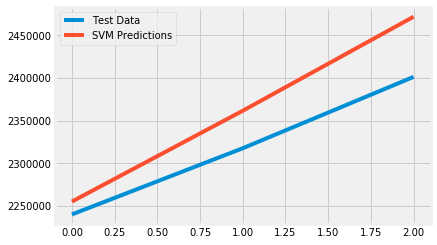

In [24]:
# check against testing data
svm_test_pred = svm_confirmed.predict(X_test_confirmed)
plt.plot(y_test_confirmed)
plt.plot(svm_test_pred)
plt.legend(['Test Data', 'SVM Predictions'])
print('MAE:', mean_absolute_error(svm_test_pred, y_test_confirmed))
print('MSE:',mean_squared_error(svm_test_pred, y_test_confirmed))

In [25]:
# transform our data for polynomial regression
poly = PolynomialFeatures(degree=3)
poly_X_train_confirmed = poly.fit_transform(X_train_confirmed)
poly_X_test_confirmed = poly.fit_transform(X_test_confirmed)
poly_future_forcast = poly.fit_transform(future_forcast)

bayesian_poly = PolynomialFeatures(degree=4)
bayesian_poly_X_train_confirmed = bayesian_poly.fit_transform(X_train_confirmed)
bayesian_poly_X_test_confirmed = bayesian_poly.fit_transform(X_test_confirmed)
bayesian_poly_future_forcast = bayesian_poly.fit_transform(future_forcast)

In [26]:
# polynomial regression
linear_model = LinearRegression(normalize=True, fit_intercept=True)
linear_model.fit(poly_X_train_confirmed, y_train_confirmed)
test_linear_pred = linear_model.predict(poly_X_test_confirmed)
linear_pred = linear_model.predict(poly_future_forcast)
print('MAE:', mean_absolute_error(test_linear_pred, y_test_confirmed))
print('MSE:',mean_squared_error(test_linear_pred, y_test_confirmed))

MAE: 168405.70927060163
MSE: 29719148200.506557


In [27]:
print(linear_model.coef_)

[[ 0.00000000e+00  2.11574701e+04 -9.14594566e+02  1.16134015e+01]]


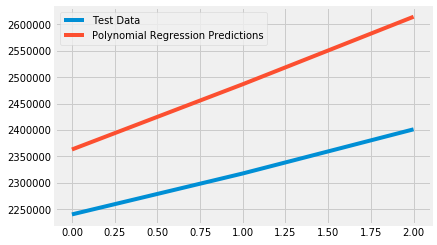

In [28]:
plt.plot(y_test_confirmed)
plt.plot(test_linear_pred)
plt.legend(['Test Data', 'Polynomial Regression Predictions'])

In [29]:
# bayesian ridge polynomial regression
tol = [1e-4, 1e-3, 1e-2]
alpha_1 = [1e-7, 1e-6, 1e-5, 1e-4]
alpha_2 = [1e-7, 1e-6, 1e-5, 1e-4]
lambda_1 = [1e-7, 1e-6, 1e-5, 1e-4]
lambda_2 = [1e-7, 1e-6, 1e-5, 1e-4]

bayesian_grid = {'tol': tol, 'alpha_1': alpha_1, 'alpha_2' : alpha_2, 'lambda_1': lambda_1, 'lambda_2' : lambda_2}

bayesian = BayesianRidge(fit_intercept=False, normalize=True)
bayesian_search = RandomizedSearchCV(bayesian, bayesian_grid, scoring='neg_mean_squared_error', cv=3, return_train_score=True, n_jobs=-1, n_iter=40, verbose=1)
bayesian_search.fit(bayesian_poly_X_train_confirmed, y_train_confirmed)

Fitting 3 folds for each of 40 candidates, totalling 120 fits
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    9.5s
[Parallel(n_jobs=-1)]: Done 105 out of 120 | elapsed:   10.7s remaining:    1.4s
[Parallel(n_jobs=-1)]: Done 120 out of 120 | elapsed:   15.2s finished


RandomizedSearchCV(cv=3, error_score=nan,
                   estimator=BayesianRidge(alpha_1=1e-06, alpha_2=1e-06,
                                           alpha_init=None, compute_score=False,
                                           copy_X=True, fit_intercept=False,
                                           lambda_1=1e-06, lambda_2=1e-06,
                                           lambda_init=None, n_iter=300,
                                           normalize=True, tol=0.001,
                                           verbose=False),
                   iid='deprecated', n_iter=40, n_jobs=-1,
                   param_distributions={'alpha_1': [1e-07, 1e-06, 1e-05,
                                                    0.0001],
                                        'alpha_2': [1e-07, 1e-06, 1e-05,
                                                    0.0001],
                                        'lambda_1': [1e-07, 1e-06, 1e-05,
                                                 

In [30]:
bayesian_search.best_params_

{'tol': 0.01,
 'lambda_2': 1e-07,
 'lambda_1': 0.0001,
 'alpha_2': 1e-06,
 'alpha_1': 1e-06}

In [31]:
bayesian_confirmed = bayesian_search.best_estimator_
test_bayesian_pred = bayesian_confirmed.predict(bayesian_poly_X_test_confirmed)
bayesian_pred = bayesian_confirmed.predict(bayesian_poly_future_forcast)
print('MAE:', mean_absolute_error(test_bayesian_pred, y_test_confirmed))
print('MSE:',mean_squared_error(test_bayesian_pred, y_test_confirmed))

MAE: 179813.6564061055
MSE: 34019927492.66936


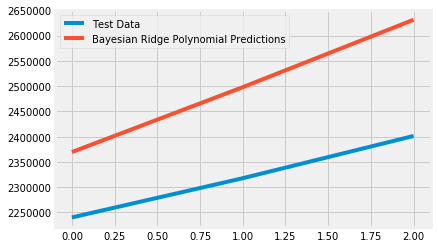

In [32]:
plt.plot(y_test_confirmed)
plt.plot(test_bayesian_pred)
plt.legend(['Test Data', 'Bayesian Ridge Polynomial Predictions'])

## Graphing the number of confirmed cases, active cases, deaths, recoveries, mortality rate, and recovery rate

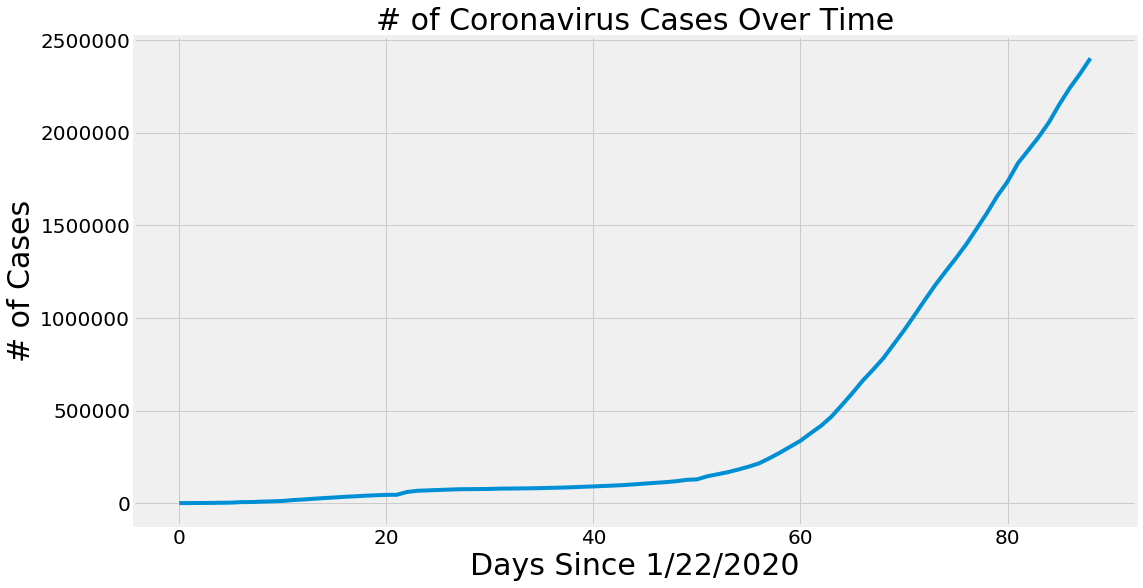

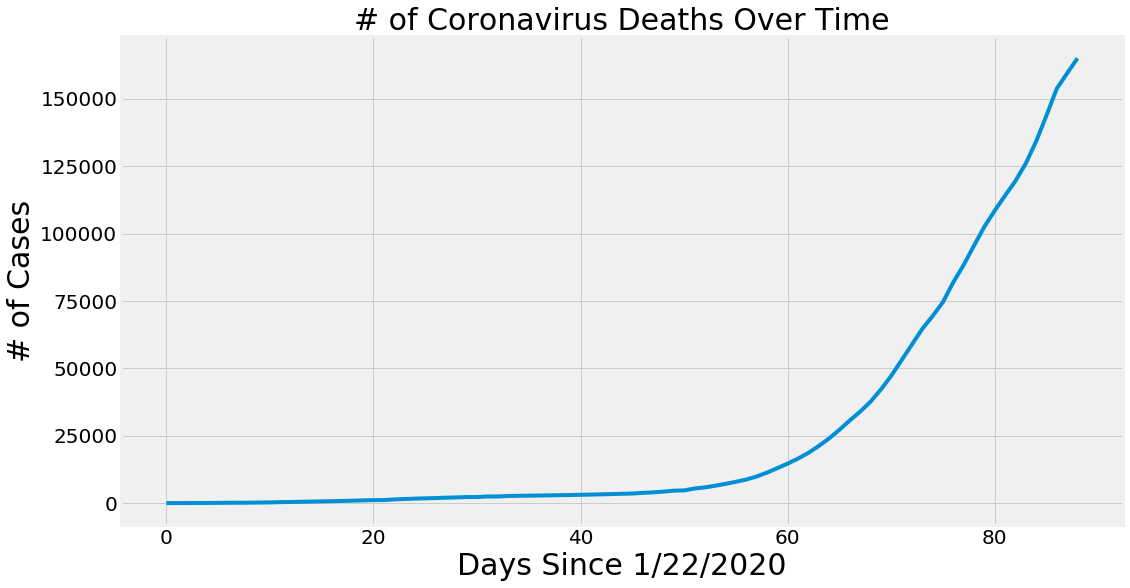

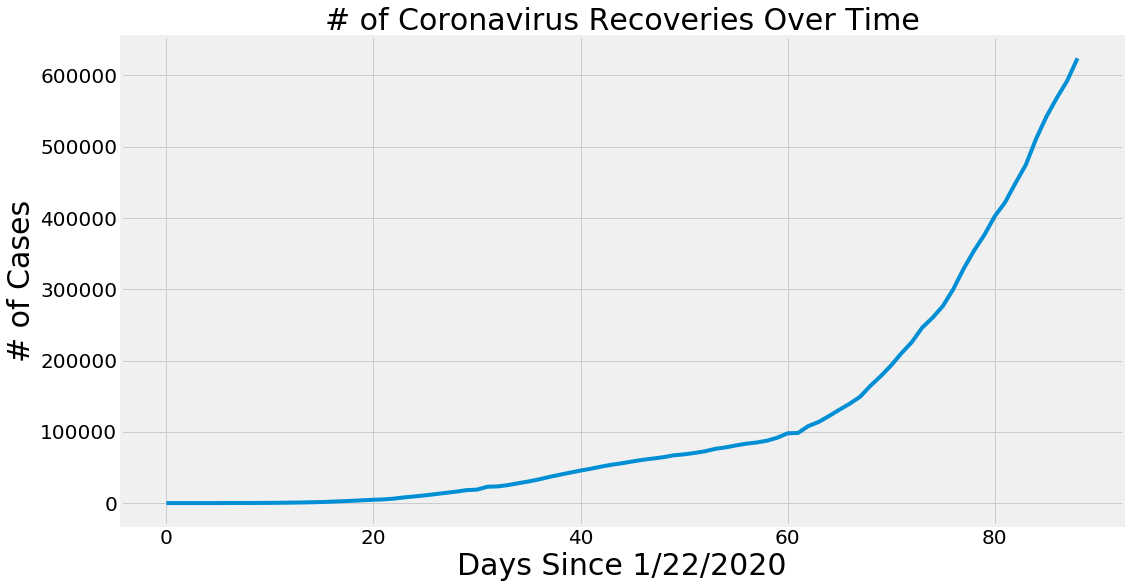

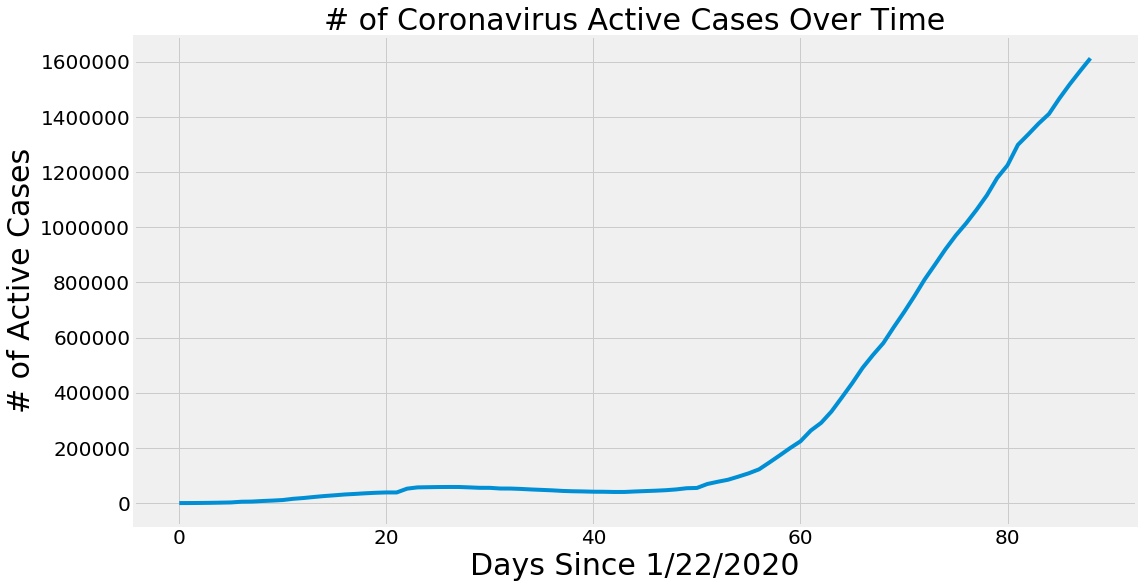

In [33]:
adjusted_dates = adjusted_dates.reshape(1, -1)[0]
plt.figure(figsize=(16, 9))
plt.plot(adjusted_dates, world_cases)
plt.title('# of Coronavirus Cases Over Time', size=30)
plt.xlabel('Days Since 1/22/2020', size=30)
plt.ylabel('# of Cases', size=30)
plt.xticks(size=20)
plt.yticks(size=20)
plt.show()

plt.figure(figsize=(16, 9))
plt.plot(adjusted_dates, total_deaths)
plt.title('# of Coronavirus Deaths Over Time', size=30)
plt.xlabel('Days Since 1/22/2020', size=30)
plt.ylabel('# of Cases', size=30)
plt.xticks(size=20)
plt.yticks(size=20)
plt.show()

plt.figure(figsize=(16, 9))
plt.plot(adjusted_dates, total_recovered)
plt.title('# of Coronavirus Recoveries Over Time', size=30)
plt.xlabel('Days Since 1/22/2020', size=30)
plt.ylabel('# of Cases', size=30)
plt.xticks(size=20)
plt.yticks(size=20)
plt.show()

plt.figure(figsize=(16, 9))
plt.plot(adjusted_dates, total_active)
plt.title('# of Coronavirus Active Cases Over Time', size=30)
plt.xlabel('Days Since 1/22/2020', size=30)
plt.ylabel('# of Active Cases', size=30)
plt.xticks(size=20)
plt.yticks(size=20)
plt.show()

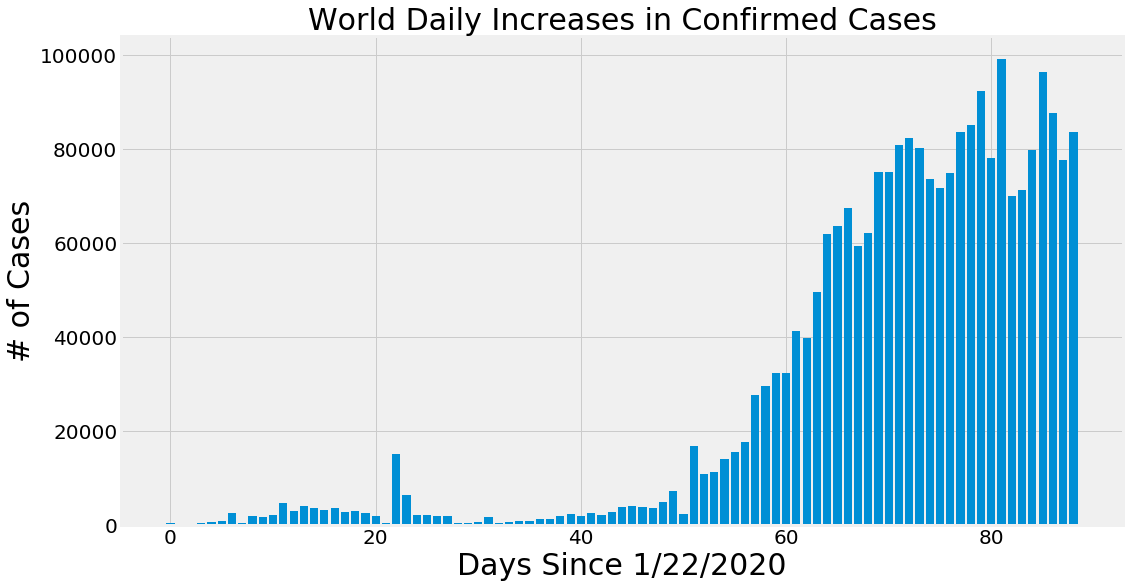

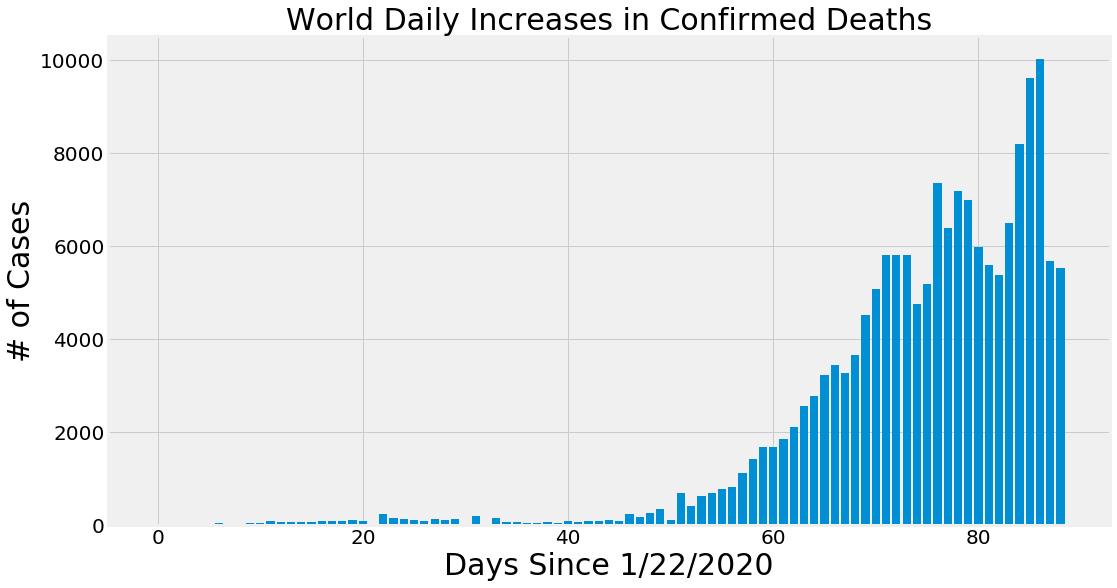

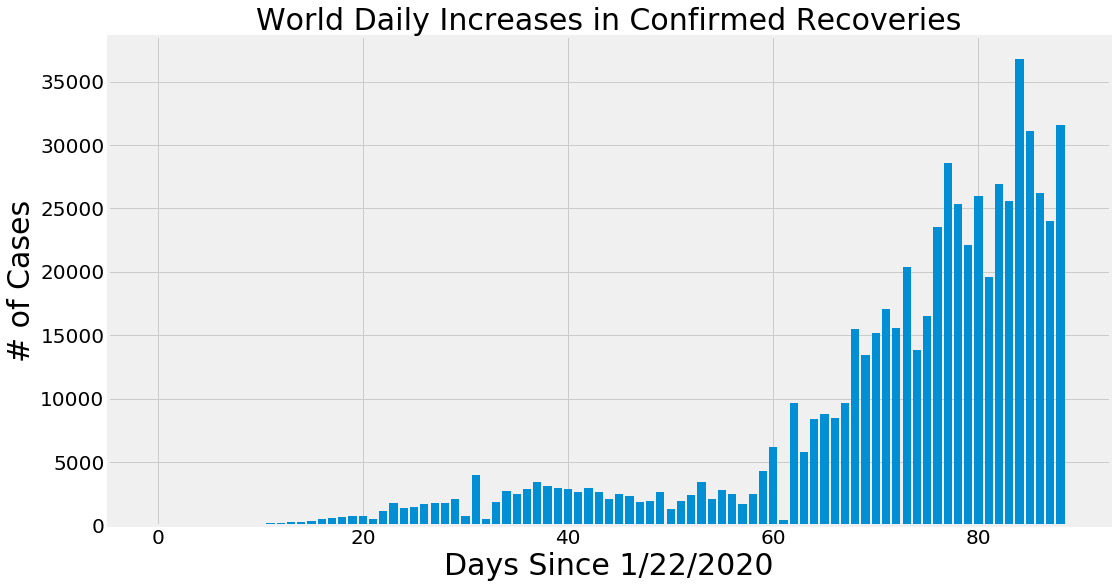

In [34]:
plt.figure(figsize=(16, 9))
plt.bar(adjusted_dates, world_daily_increase)
plt.title('World Daily Increases in Confirmed Cases', size=30)
plt.xlabel('Days Since 1/22/2020', size=30)
plt.ylabel('# of Cases', size=30)
plt.xticks(size=20)
plt.yticks(size=20)
plt.show()

plt.figure(figsize=(16, 9))
plt.bar(adjusted_dates, world_daily_death)
plt.title('World Daily Increases in Confirmed Deaths', size=30)
plt.xlabel('Days Since 1/22/2020', size=30)
plt.ylabel('# of Cases', size=30)
plt.xticks(size=20)
plt.yticks(size=20)
plt.show()

plt.figure(figsize=(16, 9))
plt.bar(adjusted_dates, world_daily_recovery)
plt.title('World Daily Increases in Confirmed Recoveries', size=30)
plt.xlabel('Days Since 1/22/2020', size=30)
plt.ylabel('# of Cases', size=30)
plt.xticks(size=20)
plt.yticks(size=20)
plt.show()

In [35]:
def country_plot(x, y1, y2, y3, y4, country):
    plt.figure(figsize=(16, 9))
    plt.plot(x, y1)
    plt.title('{} Confirmed Cases'.format(country), size=30)
    plt.xlabel('Days Since 1/22/2020', size=30)
    plt.ylabel('# of Cases', size=30)
    plt.xticks(size=20)
    plt.yticks(size=20)
    plt.show()

    plt.figure(figsize=(16, 9))
    plt.bar(x, y2)
    plt.title('{} Daily Increases in Confirmed Cases'.format(country), size=30)
    plt.xlabel('Days Since 1/22/2020', size=30)
    plt.ylabel('# of Cases', size=30)
    plt.xticks(size=20)
    plt.yticks(size=20)
    plt.show()

    plt.figure(figsize=(16, 9))
    plt.bar(x, y3)
    plt.title('{} Daily Increases in Deaths'.format(country), size=30)
    plt.xlabel('Days Since 1/22/2020', size=30)
    plt.ylabel('# of Cases', size=30)
    plt.xticks(size=20)
    plt.yticks(size=20)
    plt.show()

    plt.figure(figsize=(16, 9))
    plt.bar(x, y4)
    plt.title('{} Daily Increases in Recoveries'.format(country), size=30)
    plt.xlabel('Days Since 1/22/2020', size=30)
    plt.ylabel('# of Cases', size=30)
    plt.xticks(size=20)
    plt.yticks(size=20)
    plt.show()

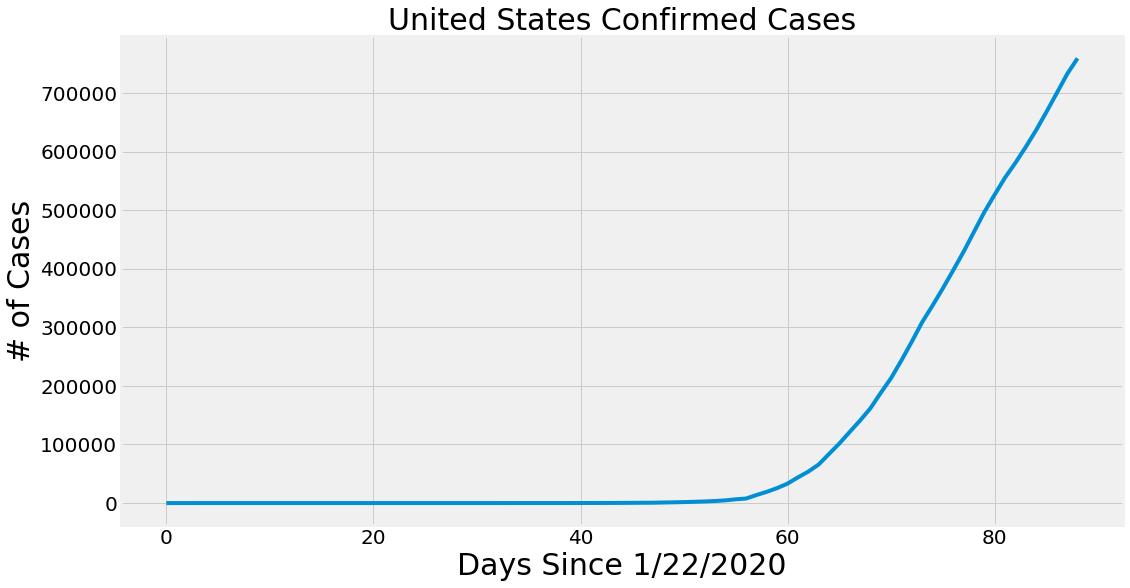

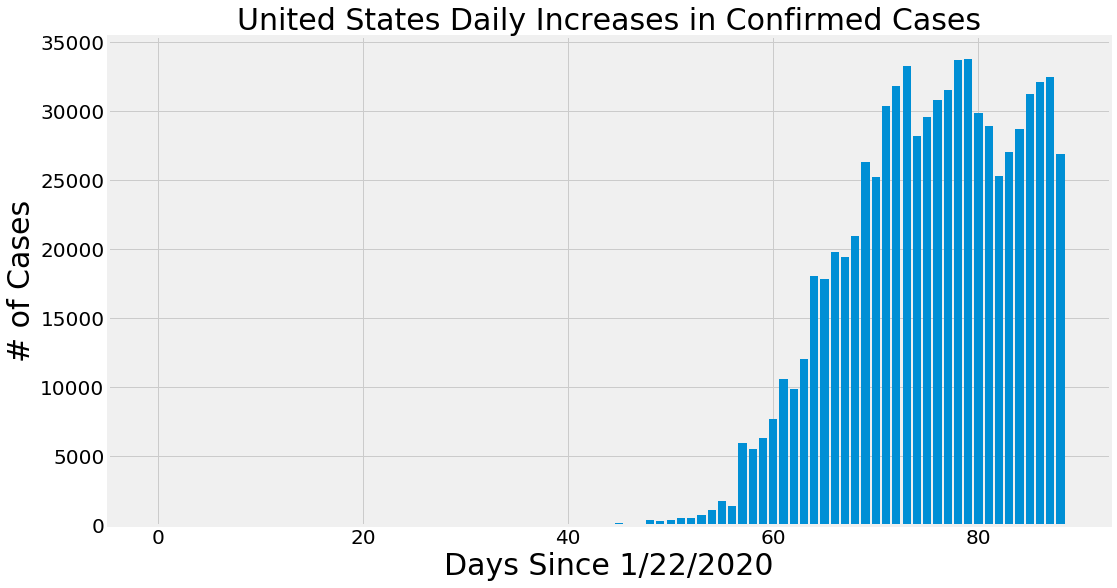

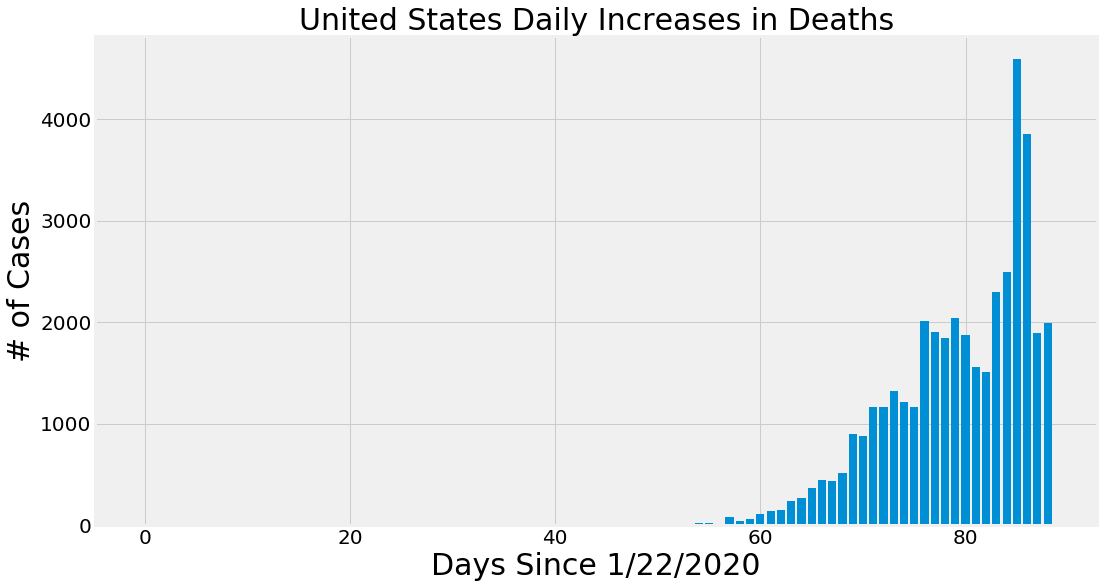

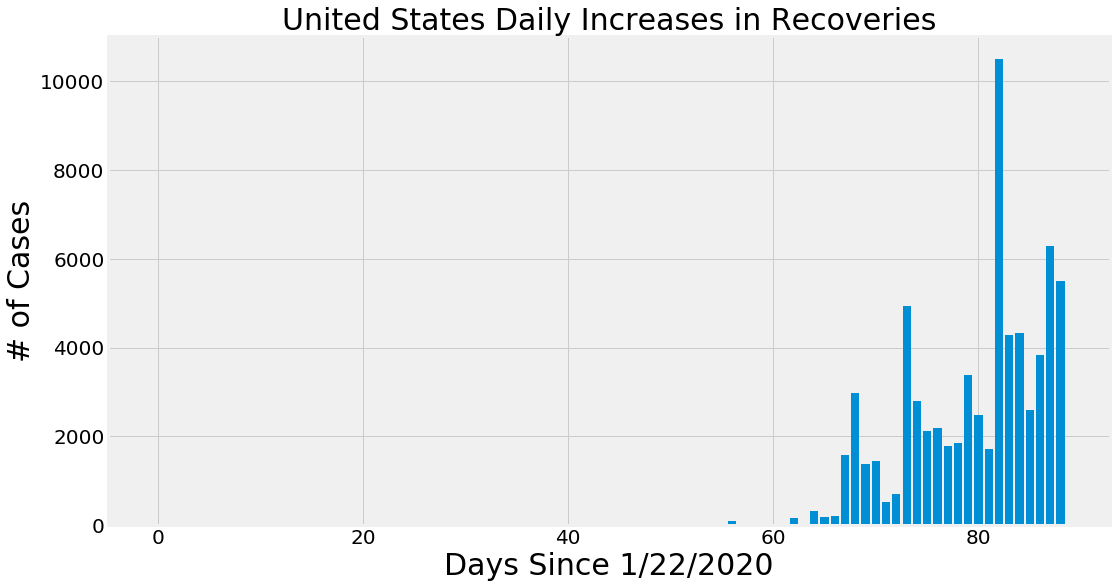

In [38]:
country_plot(adjusted_dates, us_cases, us_daily_increase, us_daily_death, us_daily_recovery, 'United States')

In [ ]:
# country_plot(adjusted_dates, china_cases, china_daily_increase, china_daily_death, china_daily_recovery, 'China')
# country_plot(adjusted_dates, italy_cases, italy_daily_increase, italy_daily_death, italy_daily_recovery, 'Italy')
# country_plot(adjusted_dates, spain_cases, spain_daily_increase, spain_daily_death, spain_daily_recovery, 'Spain')

# country_plot(adjusted_dates, france_cases, france_daily_increase, france_daily_death, france_daily_recovery, 'France')

# country_plot(adjusted_dates, germany_cases, germany_daily_increase, germany_daily_death, germany_daily_recovery, 'Germany')

# country_plot(adjusted_dates, uk_cases, uk_daily_increase, uk_daily_death, uk_daily_recovery, 'UK')

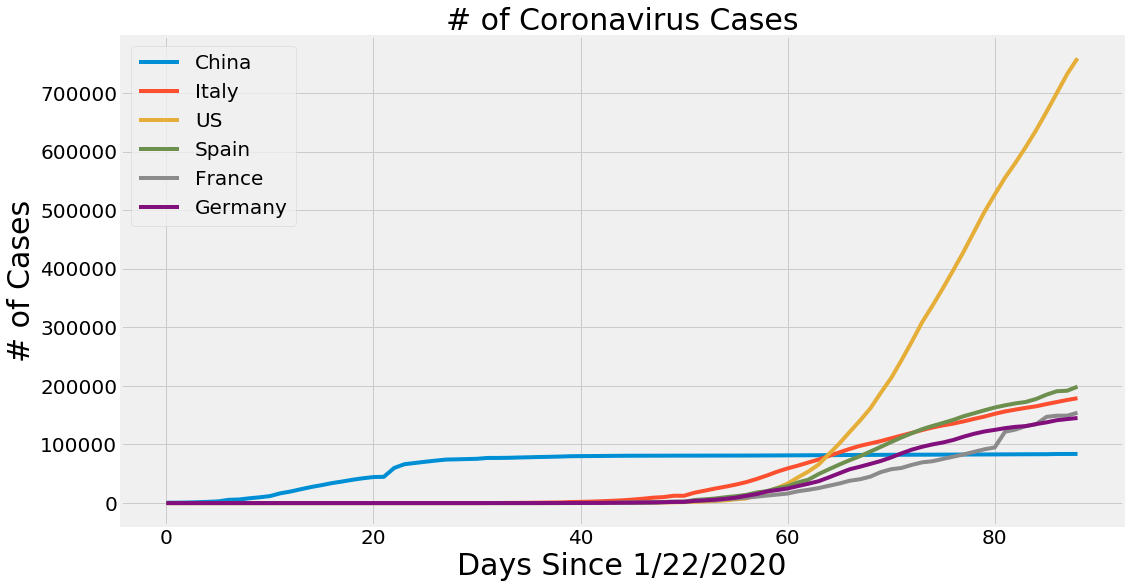

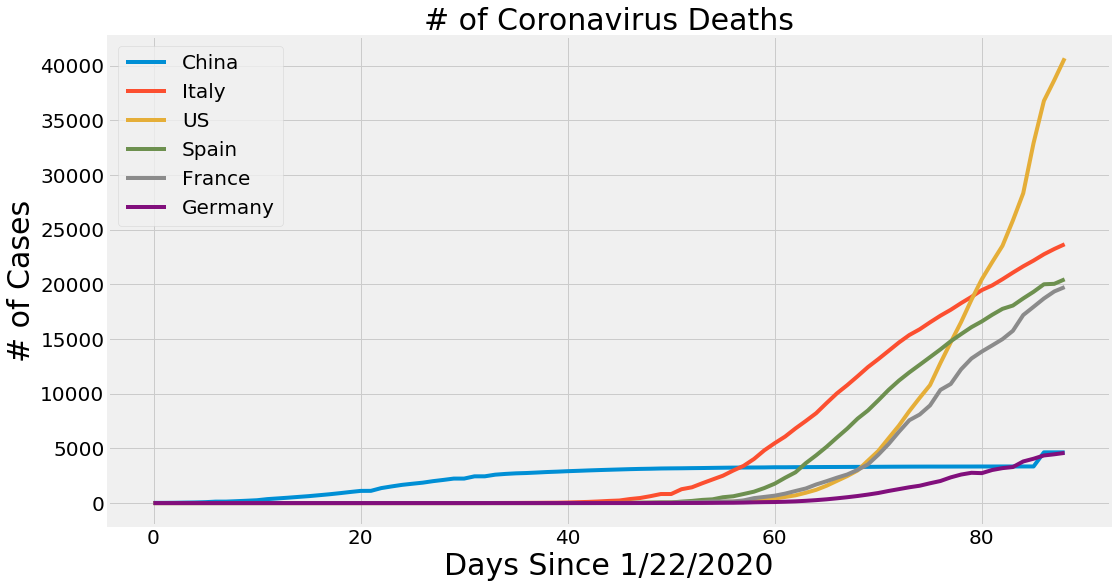

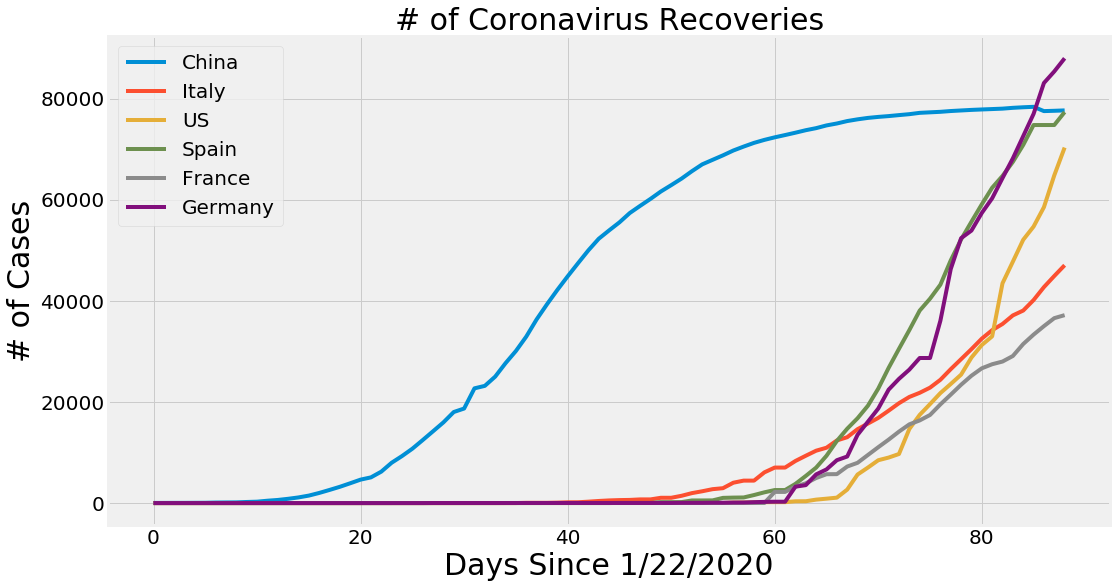

In [41]:
plt.figure(figsize=(16, 9))
plt.plot(adjusted_dates, china_cases)
plt.plot(adjusted_dates, italy_cases)
plt.plot(adjusted_dates, us_cases)
plt.plot(adjusted_dates, spain_cases)
plt.plot(adjusted_dates, france_cases)
plt.plot(adjusted_dates, germany_cases)
plt.title('# of Coronavirus Cases', size=30)
plt.xlabel('Days Since 1/22/2020', size=30)
plt.ylabel('# of Cases', size=30)
plt.legend(['China', 'Italy', 'US', 'Spain', 'France', 'Germany'], prop={'size': 20})
plt.xticks(size=20)
plt.yticks(size=20)
plt.show()

plt.figure(figsize=(16, 9))
plt.plot(adjusted_dates, china_deaths)
plt.plot(adjusted_dates, italy_deaths)
plt.plot(adjusted_dates, us_deaths)
plt.plot(adjusted_dates, spain_deaths)
plt.plot(adjusted_dates, france_deaths)
plt.plot(adjusted_dates, germany_deaths)

plt.title('# of Coronavirus Deaths', size=30)
plt.xlabel('Days Since 1/22/2020', size=30)
plt.ylabel('# of Cases', size=30)
plt.legend(['China', 'Italy', 'US', 'Spain', 'France', 'Germany'], prop={'size': 20})
plt.xticks(size=20)
plt.yticks(size=20)
plt.show()

plt.figure(figsize=(16, 9))
plt.plot(adjusted_dates, china_recoveries)
plt.plot(adjusted_dates, italy_recoveries)
plt.plot(adjusted_dates, us_recoveries)
plt.plot(adjusted_dates, spain_recoveries)
plt.plot(adjusted_dates, france_recoveries)
plt.plot(adjusted_dates, germany_recoveries)
plt.title('# of Coronavirus Recoveries', size=30)
plt.xlabel('Days Since 1/22/2020', size=30)
plt.ylabel('# of Cases', size=30)
plt.legend(['China', 'Italy', 'US', 'Spain', 'France', 'Germany'], prop={'size': 20})
plt.xticks(size=20)
plt.yticks(size=20)
plt.show()

In [42]:
def plot_predictions(x, y, pred, algo_name, color):
    plt.figure(figsize=(16, 9))
    plt.plot(x, y)
    plt.plot(future_forcast, pred, linestyle='dashed', color=color)
    plt.title('# of Coronavirus Cases Over Time', size=30)
    plt.xlabel('Days Since 1/22/2020', size=30)
    plt.ylabel('# of Cases', size=30)
    plt.legend(['Confirmed Cases', algo_name], prop={'size': 20})
    plt.xticks(size=20)
    plt.yticks(size=20)
    plt.show()

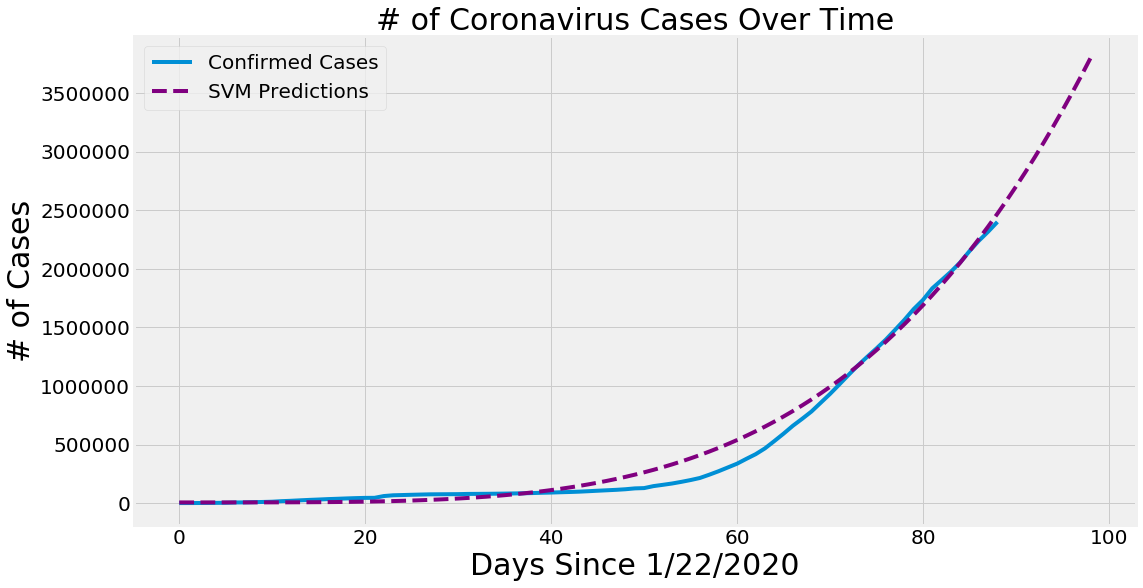

In [43]:
plot_predictions(adjusted_dates, world_cases, svm_pred, 'SVM Predictions', 'purple')

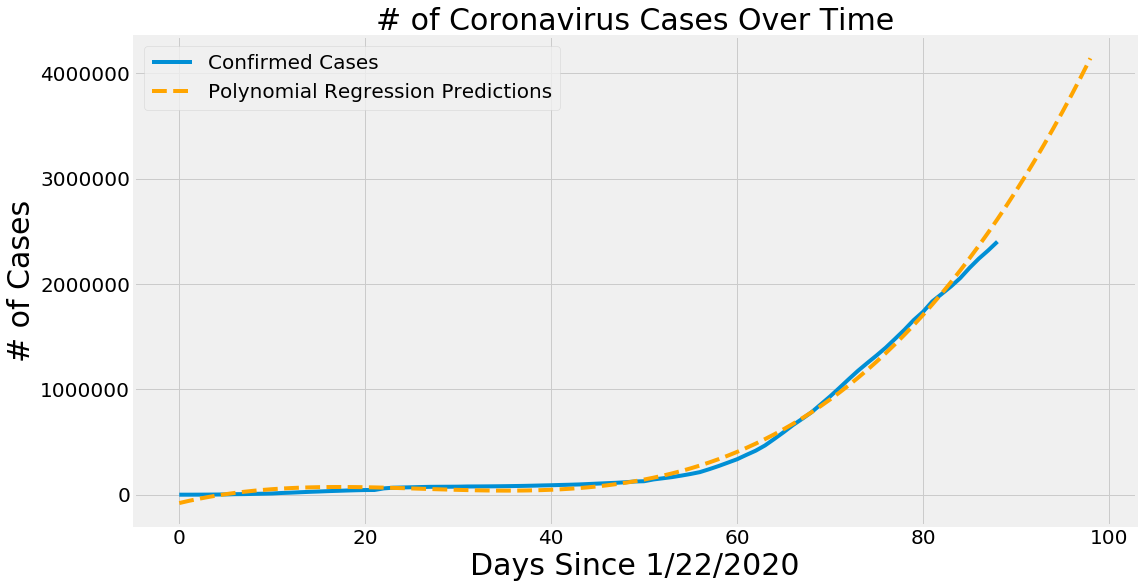

In [44]:
plot_predictions(adjusted_dates, world_cases, linear_pred, 'Polynomial Regression Predictions', 'orange')

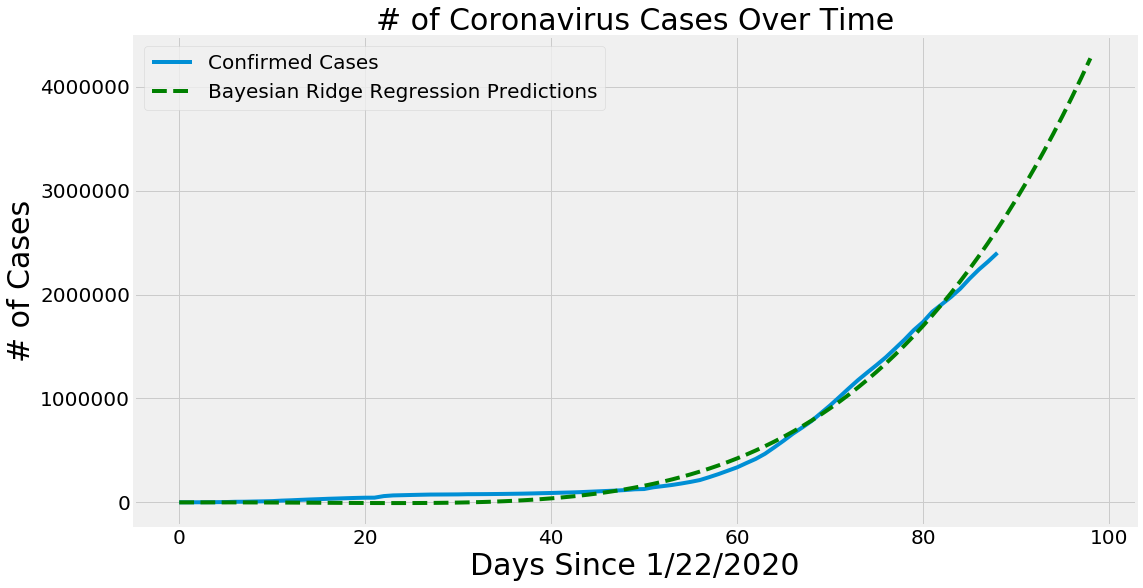

In [45]:
plot_predictions(adjusted_dates, world_cases, bayesian_pred, 'Bayesian Ridge Regression Predictions', 'green')

In [46]:
# Future predictions using SVM 
svm_df = pd.DataFrame({'Date': future_forcast_dates[-10:], 'SVM Predicted # of Confirmed Cases Worldwide': np.round(svm_pred[-10:])})
svm_df

,Date,SVM Predicted # of Confirmed Cases Worldwide
0,04/20/2020,2585885.0
1,04/21/2020,2703801.0
2,04/22/2020,2825714.0
3,04/23/2020,2951712.0
4,04/24/2020,3081887.0
5,04/25/2020,3216330.0
6,04/26/2020,3355132.0
7,04/27/2020,3498387.0
8,04/28/2020,3646190.0
9,04/29/2020,3798636.0


In [47]:
# Future predictions using polynomial regression
linear_pred = linear_pred.reshape(1,-1)[0]
svm_df = pd.DataFrame({'Date': future_forcast_dates[-10:], 'Polynomial Predicted # of Confirmed Cases Worldwide': np.round(linear_pred[-10:])})
svm_df

,Date,Polynomial Predicted # of Confirmed Cases Worldwide
0,04/20/2020,2746776.0
1,04/21/2020,2883303.0
2,04/22/2020,3024271.0
3,04/23/2020,3169752.0
4,04/24/2020,3319814.0
5,04/25/2020,3474527.0
6,04/26/2020,3633960.0
7,04/27/2020,3798185.0
8,04/28/2020,3967269.0
9,04/29/2020,4141283.0


In [48]:
# Future predictions using Bayesian Ridge 
svm_df = pd.DataFrame({'Date': future_forcast_dates[-10:], 'Bayesian Ridge Predicted # of Confirmed Cases Worldwide': np.round(bayesian_pred[-10:])})
svm_df

,Date,Bayesian Ridge Predicted # of Confirmed Cases Worldwide
0,04/20/2020,2769957.0
1,04/21/2020,2913911.0
2,04/22/2020,3063326.0
3,04/23/2020,3218338.0
4,04/24/2020,3379082.0
5,04/25/2020,3545697.0
6,04/26/2020,3718322.0
7,04/27/2020,3897100.0
8,04/28/2020,4082172.0
9,04/29/2020,4273684.0


### Mortality Rate (worldwide) **susceptible to change **

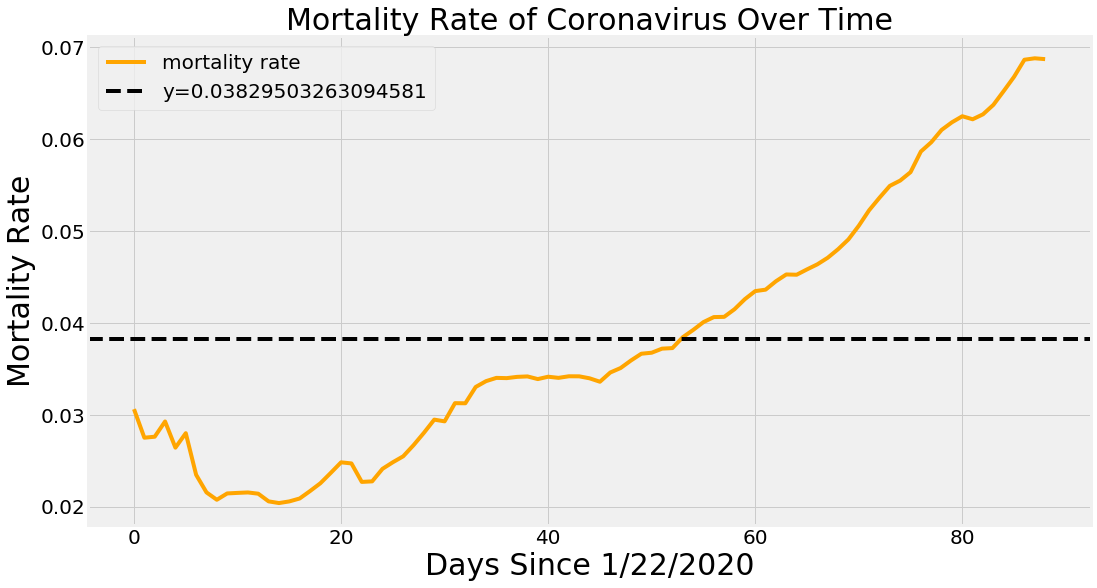

In [49]:
mean_mortality_rate = np.mean(mortality_rate)
plt.figure(figsize=(16, 9))
plt.plot(adjusted_dates, mortality_rate, color='orange')
plt.axhline(y = mean_mortality_rate,linestyle='--', color='black')
plt.title('Mortality Rate of Coronavirus Over Time', size=30)
plt.legend(['mortality rate', 'y='+str(mean_mortality_rate)], prop={'size': 20})
plt.xlabel('Days Since 1/22/2020', size=30)
plt.ylabel('Mortality Rate', size=30)
plt.xticks(size=20)
plt.yticks(size=20)
plt.show()

### Recovery Rate (worldwide) **susceptible to change **

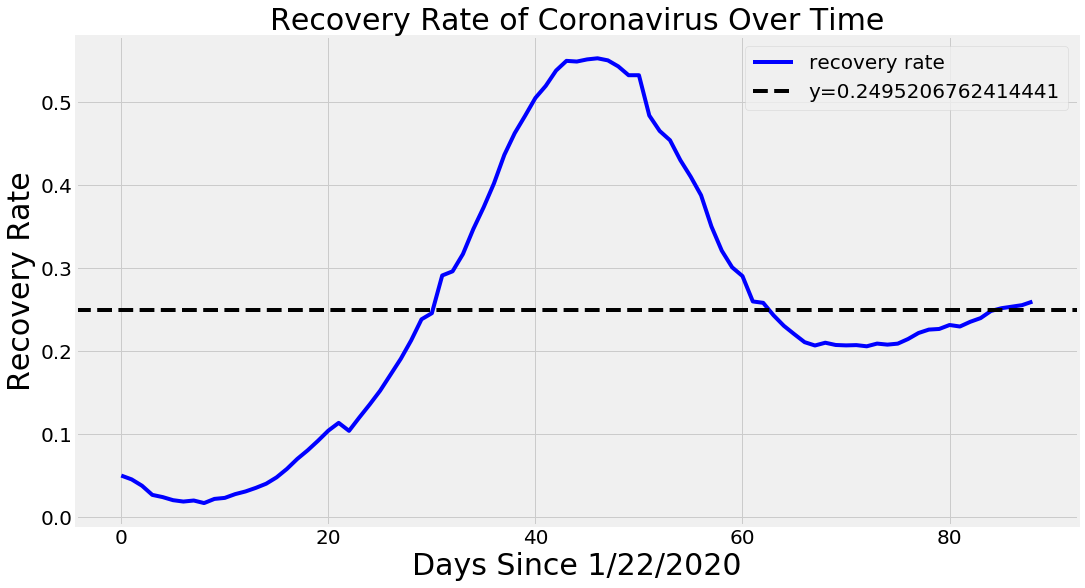

In [50]:
mean_recovery_rate = np.mean(recovery_rate)
plt.figure(figsize=(16, 9))
plt.plot(adjusted_dates, recovery_rate, color='blue')
plt.axhline(y = mean_recovery_rate,linestyle='--', color='black')
plt.title('Recovery Rate of Coronavirus Over Time', size=30)
plt.legend(['recovery rate', 'y='+str(mean_recovery_rate)], prop={'size': 20})
plt.xlabel('Days Since 1/22/2020', size=30)
plt.ylabel('Recovery Rate', size=30)
plt.xticks(size=20)
plt.yticks(size=20)
plt.show()

In [ ]:
Graphing deaths against recoveries

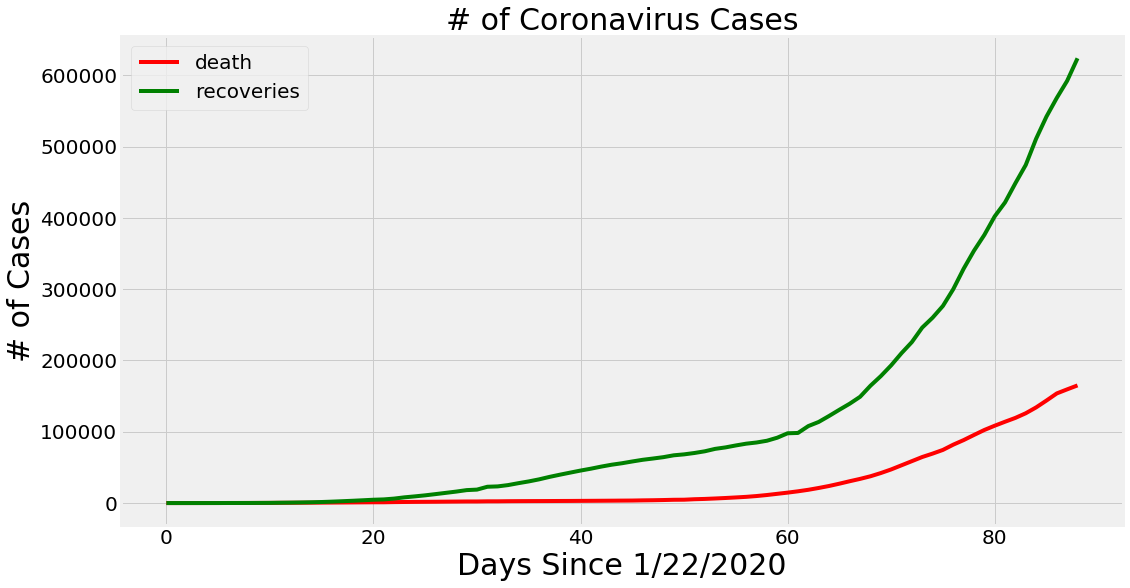

In [51]:
plt.figure(figsize=(16, 9))
plt.plot(adjusted_dates, total_deaths, color='r')
plt.plot(adjusted_dates, total_recovered, color='green')
plt.legend(['death', 'recoveries'], loc='best', fontsize=20)
plt.title('# of Coronavirus Cases', size=30)
plt.xlabel('Days Since 1/22/2020', size=30)
plt.ylabel('# of Cases', size=30)
plt.xticks(size=20)
plt.yticks(size=20)
plt.show()

### Plotting the number of deaths against the number of recoveries

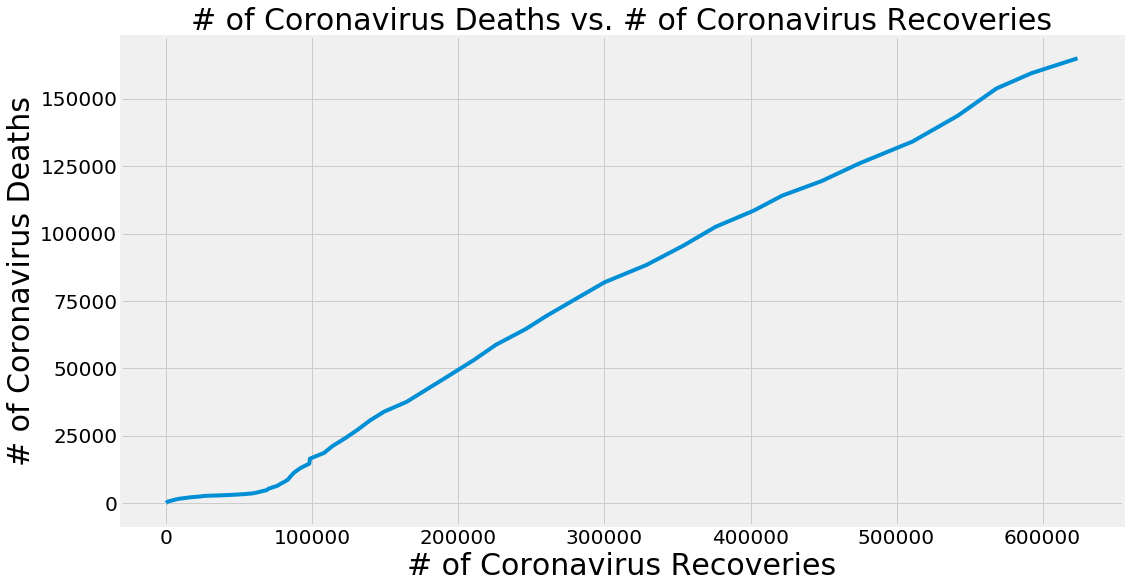

In [52]:
plt.figure(figsize=(16, 9))
plt.plot(total_recovered, total_deaths)
plt.title('# of Coronavirus Deaths vs. # of Coronavirus Recoveries', size=30)
plt.xlabel('# of Coronavirus Recoveries', size=30)
plt.ylabel('# of Coronavirus Deaths', size=30)
plt.xticks(size=20)
plt.yticks(size=20)
plt.show()

### Getting information about countries/regions that have confirmed coronavirus cases

In [54]:
unique_countries =  list(latest_data['Country_Region'].unique())

print(unique_countries)

['US', 'Canada', 'United Kingdom', 'China', 'Netherlands', 'Australia', 'Denmark', 'France', 'Afghanistan', 'Albania', 'Algeria', 'Andorra', 'Angola', 'Antigua and Barbuda', 'Argentina', 'Armenia', 'Austria', 'Azerbaijan', 'Bahamas', 'Bahrain', 'Bangladesh', 'Barbados', 'Belarus', 'Belgium', 'Belize', 'Benin', 'Bhutan', 'Bolivia', 'Bosnia and Herzegovina', 'Botswana', 'Brazil', 'Brunei', 'Bulgaria', 'Burkina Faso', 'Burma', 'Burundi', 'Cabo Verde', 'Cambodia', 'Cameroon', 'Central African Republic', 'Chad', 'Chile', 'Colombia', 'Congo (Brazzaville)', 'Congo (Kinshasa)', 'Costa Rica', "Cote d'Ivoire", 'Croatia', 'Cuba', 'Cyprus', 'Czechia', 'Diamond Princess', 'Djibouti', 'Dominica', 'Dominican Republic', 'Ecuador', 'Egypt', 'El Salvador', 'Equatorial Guinea', 'Eritrea', 'Estonia', 'Eswatini', 'Ethiopia', 'Fiji', 'Finland', 'Gabon', 'Gambia', 'Georgia', 'Germany', 'Ghana', 'Greece', 'Grenada', 'Guatemala', 'Guinea', 'Guinea-Bissau', 'Guyana', 'Haiti', 'Holy See', 'Honduras', 'Hungary', 

In [55]:
country_confirmed_cases = []
country_death_cases = [] 
country_active_cases = []
country_recovery_cases = []
country_mortality_rate = [] 

no_cases = []
for i in unique_countries:
    cases = latest_data[latest_data['Country_Region']==i]['Confirmed'].sum()
    if cases > 0:
        country_confirmed_cases.append(cases)
    else:
        no_cases.append(i)
        
for i in no_cases:
    unique_countries.remove(i)
    
# sort countries by the number of confirmed cases
unique_countries = [k for k, v in sorted(zip(unique_countries, country_confirmed_cases), key=operator.itemgetter(1), reverse=True)]
for i in range(len(unique_countries)):
    country_confirmed_cases[i] = latest_data[latest_data['Country_Region']==unique_countries[i]]['Confirmed'].sum()
    country_death_cases.append(latest_data[latest_data['Country_Region']==unique_countries[i]]['Deaths'].sum())
    country_recovery_cases.append(latest_data[latest_data['Country_Region']==unique_countries[i]]['Recovered'].sum())
    country_active_cases.append(country_confirmed_cases[i] - country_death_cases[i] - country_recovery_cases[i])
    country_mortality_rate.append(country_death_cases[i]/country_confirmed_cases[i])

In [56]:
country_df = pd.DataFrame({'Country Name': unique_countries, 'Number of Confirmed Cases': country_confirmed_cases,
                          'Number of Deaths': country_death_cases, 'Number of Recoveries' : country_recovery_cases, 
                          'Number of Active Cases' : country_active_cases,
                          'Mortality Rate': country_mortality_rate})
# number of cases per country/region

country_df.style.background_gradient(cmap='Greens')

,Country Name,Number of Confirmed Cases,Number of Deaths,Number of Recoveries,Number of Active Cases,Mortality Rate
0,US,759086,40661,70337,648088,0.0535657
1,Spain,198674,20453,77357,100864,0.102948
2,Italy,178972,23660,47055,108257,0.132199
3,France,154097,19744,37183,97170,0.128127
4,Germany,145184,4586,88000,52598,0.0315875
5,United Kingdom,121172,16095,436,104641,0.132828
6,Turkey,86306,2017,11976,72313,0.0233703
7,China,83805,4636,77690,1479,0.0553189
8,Iran,82211,5118,57023,20070,0.0622544
9,Russia,42853,361,3291,39201,0.00842415


In [57]:
unique_provinces =  list(latest_data['Province_State'].unique())

In [59]:
### Getting the latest information about provinces/states that have confirmed coronavirus cases

In [61]:
province_confirmed_cases = []
province_country = [] 
province_death_cases = [] 
province_recovery_cases = []
province_mortality_rate = [] 

no_cases = [] 
for i in unique_provinces:
    cases = latest_data[latest_data['Province_State']==i]['Confirmed'].sum()
    if cases > 0:
        province_confirmed_cases.append(cases)
    else:
        no_cases.append(i)
 
# remove areas with no confirmed cases
for i in no_cases:
    unique_provinces.remove(i)
    
unique_provinces = [k for k, v in sorted(zip(unique_provinces, province_confirmed_cases), key=operator.itemgetter(1), reverse=True)]
for i in range(len(unique_provinces)):
    province_confirmed_cases[i] = latest_data[latest_data['Province_State']==unique_provinces[i]]['Confirmed'].sum()
    province_country.append(latest_data[latest_data['Province_State']==unique_provinces[i]]['Country_Region'].unique()[0])
    province_death_cases.append(latest_data[latest_data['Province_State']==unique_provinces[i]]['Deaths'].sum())
    province_recovery_cases.append(latest_data[latest_data['Province_State']==unique_provinces[i]]['Recovered'].sum())
    province_mortality_rate.append(province_death_cases[i]/province_confirmed_cases[i])

In [62]:
# number of cases per province/state/city
province_df = pd.DataFrame({'Province/State Name': unique_provinces, 'Country': province_country, 'Number of Confirmed Cases': province_confirmed_cases,
                          'Number of Deaths': province_death_cases, 'Number of Recoveries' : province_recovery_cases,
                          'Mortality Rate': province_mortality_rate})
# number of cases per country/region

province_df.style.background_gradient(cmap='Greens')

,Province/State Name,Country,Number of Confirmed Cases,Number of Deaths,Number of Recoveries,Mortality Rate
0,New York,US,247815,18298,0,0.0738373
1,New Jersey,US,85301,4362,0,0.0511366
2,Hubei,China,68128,4512,63507,0.0662283
3,Massachusetts,US,38077,1706,0,0.0448039
4,Pennsylvania,US,32902,1276,0,0.0387818
5,California,US,31431,1177,0,0.0374471
6,Michigan,US,31424,2391,0,0.0760883
7,Illinois,US,30357,1290,0,0.0424943
8,Florida,US,26314,774,0,0.029414
9,Louisiana,US,23928,1296,0,0.0541625


In [63]:
nan_indices = [] 

# handle nan if there is any, it is usually a float: float('nan')

for i in range(len(unique_provinces)):
    if type(unique_provinces[i]) == float:
        nan_indices.append(i)

unique_provinces = list(unique_provinces)
province_confirmed_cases = list(province_confirmed_cases)

for i in nan_indices:
    unique_provinces.pop(i)
    province_confirmed_cases.pop(i)

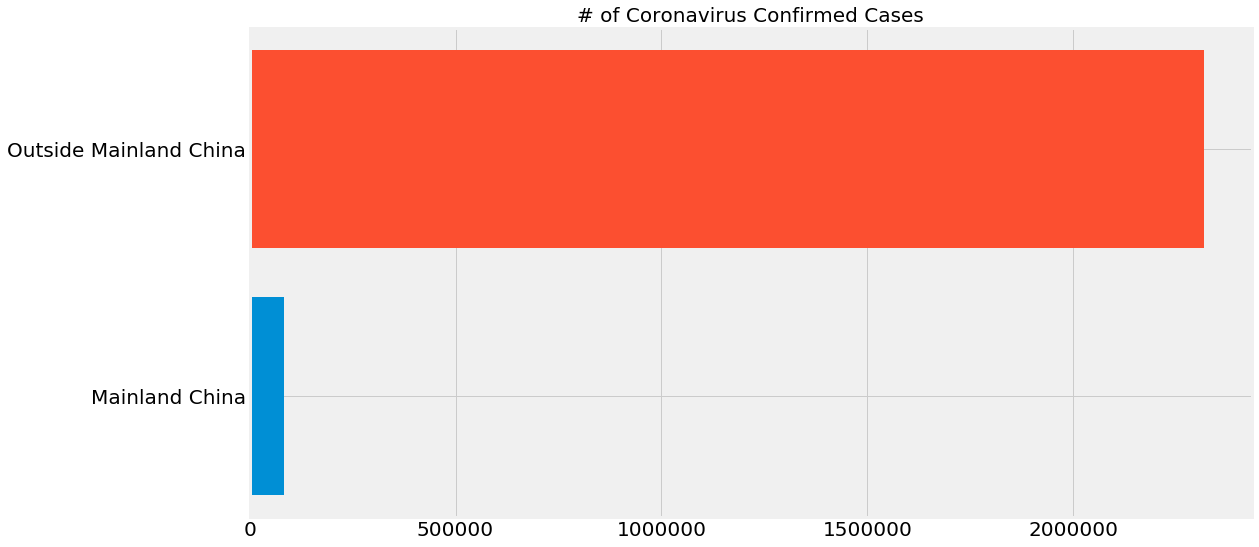

In [64]:
china_confirmed = latest_data[latest_data['Country_Region']=='China']['Confirmed'].sum()
outside_mainland_china_confirmed = np.sum(country_confirmed_cases) - china_confirmed
plt.figure(figsize=(16, 9))
plt.barh('Mainland China', china_confirmed)
plt.barh('Outside Mainland China', outside_mainland_china_confirmed)
plt.title('# of Coronavirus Confirmed Cases', size=20)
plt.xticks(size=20)
plt.yticks(size=20)
plt.show()

In [65]:
print('Outside Mainland China {} cases:'.format(outside_mainland_china_confirmed))
print('Mainland China: {} cases'.format(china_confirmed))
print('Total: {} cases'.format(china_confirmed+outside_mainland_china_confirmed))

Outside Mainland China 2317574 cases:
Mainland China: 83805 cases
Total: 2401379 cases


In [66]:
# Only show 10 countries with the most confirmed cases, the rest are grouped into the other category
visual_unique_countries = [] 
visual_confirmed_cases = []
others = np.sum(country_confirmed_cases[10:])

for i in range(len(country_confirmed_cases[:10])):
    visual_unique_countries.append(unique_countries[i])
    visual_confirmed_cases.append(country_confirmed_cases[i])
    
visual_unique_countries.append('Others')
visual_confirmed_cases.append(others)

### The last parts has to be added: from ""Visual representations"